## Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import math

## Data initialization
### Read input data

In [2]:
data = pd.read_csv('COVID19MEXICO2021.csv', low_memory=False);

Show column names, only certain columns will be used

In [3]:
data.columns

Index(['FECHA_ACTUALIZACION', 'ID_REGISTRO', 'ORIGEN', 'SECTOR', 'ENTIDAD_UM',
       'SEXO', 'ENTIDAD_NAC', 'ENTIDAD_RES', 'MUNICIPIO_RES', 'TIPO_PACIENTE',
       'FECHA_INGRESO', 'FECHA_SINTOMAS', 'FECHA_DEF', 'INTUBADO', 'NEUMONIA',
       'EDAD', 'NACIONALIDAD', 'EMBARAZO', 'HABLA_LENGUA_INDIG', 'INDIGENA',
       'DIABETES', 'EPOC', 'ASMA', 'INMUSUPR', 'HIPERTENSION', 'OTRA_COM',
       'CARDIOVASCULAR', 'OBESIDAD', 'RENAL_CRONICA', 'TABAQUISMO',
       'OTRO_CASO', 'TOMA_MUESTRA_LAB', 'RESULTADO_LAB',
       'TOMA_MUESTRA_ANTIGENO', 'RESULTADO_ANTIGENO', 'CLASIFICACION_FINAL',
       'MIGRANTE', 'PAIS_NACIONALIDAD', 'PAIS_ORIGEN', 'UCI'],
      dtype='object')

Split the input data, only data from 2021 is taken, also, select only the columns thar are useful for the classifier

In [4]:
datacopy = data[(data['FECHA_INGRESO'] < '2022-01-01')  & (data['CLASIFICACION_FINAL'].between(1, 3))][['SEXO', 'TIPO_PACIENTE', 'EDAD', 'DIABETES', 'EPOC', 'ASMA', 'INMUSUPR', 'HIPERTENSION', 'OTRA_COM', 'CARDIOVASCULAR', 'OBESIDAD', 'RENAL_CRONICA', 'TABAQUISMO', 'FECHA_DEF']]

In [5]:
datacopy

,SEXO,TIPO_PACIENTE,EDAD,DIABETES,EPOC,ASMA,INMUSUPR,HIPERTENSION,OTRA_COM,CARDIOVASCULAR,OBESIDAD,RENAL_CRONICA,TABAQUISMO,FECHA_DEF
6,1,1,36,1,2,2,2,2,2,2,2,2,2,9999-99-99
10,1,1,63,2,2,1,2,2,1,1,2,2,2,9999-99-99
16,1,1,18,2,2,2,2,2,2,2,2,2,2,9999-99-99
57,1,1,44,2,2,2,2,1,2,2,1,2,2,9999-99-99
63,1,1,61,1,2,2,2,2,2,2,2,2,2,9999-99-99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8830180,1,1,22,2,2,2,2,2,98,2,2,2,2,9999-99-99
8830182,1,1,21,2,2,2,2,2,98,2,2,2,2,9999-99-99
8830186,1,1,18,2,2,2,2,2,98,2,2,2,2,9999-99-99
8830205,2,1,31,2,2,2,2,2,98,2,2,2,2,9999-99-99


The date is replaced for a bool that tells if the patient survived

In [6]:
datacopy['FECHA_DEF'] = np.where(datacopy['FECHA_DEF'] == "9999-99-99", 1, 0)

datacopy = datacopy.drop(datacopy[(datacopy['SEXO'] == 99) | (datacopy['TIPO_PACIENTE'] == 99) |
                                  (datacopy['DIABETES'] != 1 ) & (datacopy['DIABETES'] != 2 ) |
                                  (datacopy['EPOC'] != 1 ) & (datacopy['EPOC'] != 2 ) |
                                  (datacopy['ASMA'] != 1 ) & (datacopy['ASMA'] != 2 ) |
                                  (datacopy['INMUSUPR'] != 1 ) & (datacopy['INMUSUPR'] != 2 ) |
                                  (datacopy['HIPERTENSION'] != 1 ) & (datacopy['HIPERTENSION'] != 2 ) |
                                  (datacopy['OTRA_COM'] != 1 ) & (datacopy['OTRA_COM'] != 2 ) |
                                  (datacopy['CARDIOVASCULAR'] != 1 ) & (datacopy['CARDIOVASCULAR'] != 2 ) |
                                  (datacopy['OBESIDAD'] != 1 ) & (datacopy['OBESIDAD'] != 2 ) |
                                  (datacopy['RENAL_CRONICA'] != 1 ) & (datacopy['RENAL_CRONICA'] != 2 ) |
                                  (datacopy['TABAQUISMO'] != 1 ) & (datacopy['TABAQUISMO'] != 2 )].index)

datacopy.rename(columns={'FECHA_DEF': 'SOBREVIVIO'}, inplace=True)

In [7]:
col = 'EDAD'
datacopy.sort_values(col)[col].tail(500)

7648152    100
6885999    100
6698733    100
2432320    100
2003184    100
          ... 
1404132    121
2051964    121
2004104    121
957126     121
5273124    121
Name: EDAD, Length: 500, dtype: int64

Data info, the number of colums will be used to limit the decision tree depth

In [8]:
datacopy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2470794 entries, 6 to 8708284
Data columns (total 14 columns):
 #   Column          Dtype
---  ------          -----
 0   SEXO            int64
 1   TIPO_PACIENTE   int64
 2   EDAD            int64
 3   DIABETES        int64
 4   EPOC            int64
 5   ASMA            int64
 6   INMUSUPR        int64
 7   HIPERTENSION    int64
 8   OTRA_COM        int64
 9   CARDIOVASCULAR  int64
 10  OBESIDAD        int64
 11  RENAL_CRONICA   int64
 12  TABAQUISMO      int64
 13  SOBREVIVIO      int32
dtypes: int32(1), int64(13)
memory usage: 273.3 MB


## Classifier

Define the features

In [9]:
features = ['SEXO', 'TIPO_PACIENTE', 'EDAD', 'DIABETES', 'EPOC', 'ASMA', 'INMUSUPR', 'HIPERTENSION', 'OTRA_COM', 'CARDIOVASCULAR', 'OBESIDAD', 'RENAL_CRONICA', 'TABAQUISMO']

Set the X and Y axes used to train the classifier

In [10]:
X = datacopy[features]
Y = datacopy['SOBREVIVIO']

Split the data

In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

Fit the classifier (Training)

In [12]:
decisionTree = tree.DecisionTreeClassifier(max_leaf_nodes=30 ,random_state=42)
decisionTree.fit(X_train, Y_train)

DecisionTreeClassifier(max_leaf_nodes=30, random_state=42)

In [13]:
Y_pred = decisionTree.predict(X_test)

## Classifier results

In [14]:
decisionTree.score(X_test,Y_test)

0.9564013766140206

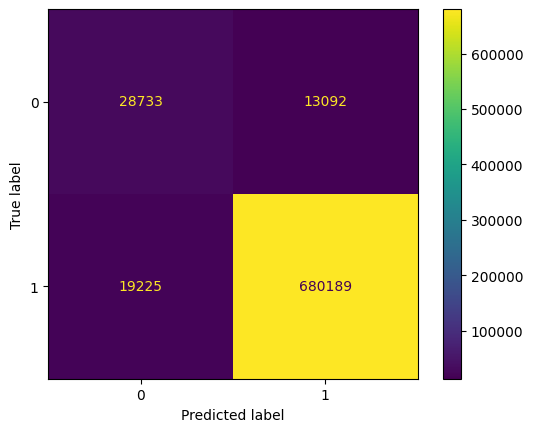

In [19]:
cm = confusion_matrix(Y_test, Y_pred)
ConfusionMatrixDisplay(cm).plot()

In [23]:
tN = cm[0][0]
tP = cm[1][1]
fN = cm[1][0]
fP = cm[0][1]

# Accuracy (Exactitud)
# (TN+TP)/(TN+TP+FN+FP)
accuracy = (tN + tP) / (tN + tP + fN + fP)
print("Accuracy: " + str(round(accuracy, ndigits=4)) + " = " + str(round(accuracy*100, ndigits=2)) + "%")

# Precision (Calidad) 
# TP/(TP+FP)
precision = tP / (tP + fP)
print("Precision: " + str(round(precision, ndigits=4)) + " = " + str(round(precision*100, ndigits=2)) + "%")

# Recall (Sensibilidad)
# TP/(TP+FN)
recall = tP / (tP + fN)
print("Recall: " + str(round(recall, ndigits=4)) + " = " + str(round(recall*100, ndigits=2)) + "%")

# Solo para matriz de confusión 2x2
# F1 = 2 * ((PRECISION * RECALL)/(PRECISION + RECALL))
f1 = 2 * ((precision * recall) / (precision + recall))
print("F1: " + str(round(f1, ndigits=4)) + " = " + str(round(f1*100, ndigits=2)) + "%")

Accuracy: 0.9564 = 95.64%
Precision: 0.9811 = 98.11%
Recall: 0.9725 = 97.25%
F1: 0.9768 = 97.68%


## Decision tree graph

Generate graph

In [24]:
import graphviz 
dot_data = tree.export_graphviz(decisionTree, out_file=None, class_names= ['Sobrevivio', 'No Sobrevivio'], feature_names=features, filled=True, rounded=True, special_characters=True)
graph = graphviz.Source(dot_data)

Export graph to PDF

In [25]:
graph.render("C19_DecisionTree")

'C19_DecisionTree.pdf'